# Area sampling using Dask and Xarray
Computational improvement based on test_area_sample_PETandLtheta.ipynb

In [1]:
from dask.distributed import Client
import xarray as xr
import numpy as np
from datetime import datetime
import os
import rasterio as rio
import glob
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from osgeo import gdal
import cartopy.crs as ccrs

In [1]:
###### Define constants ###########

# Changable

# Area
network_name = "California"
minx = -124.5
miny = 32.5
maxx = -114
maxy = 42.5
bbox = {'minx':minx, 'maxx':maxx, 'miny':miny, 'maxy':maxy}

# Chunks
chunks = {'x': 10, 'y': 10}

# Thresholds
lower_quantile_thresh = 0.25
upper_quantile_thresh = 0.75
precip_thresh = 0.00002

# Dates
startDate = datetime(2016, 1, 1)
endDate = datetime(2017, 1, 1)

# Non-changable
SMAPL4_times = ['0130', '0430', '0730', '1030', '1330', '1630', '1930', '2230'] # 3-hourly data

###### PATH ###########
input_path = r"..\1_data"
output_path = r"..\3_data_out"
SMAPL3_path = "SPL3SMP_E"
SMAPL4_path = "SPL4SMGP"
SMAPL4_grid_path = "SMAPL4SMGP_EASEreference"
PET_path = "PET"

NameError: name 'datetime' is not defined

In [3]:
client = Client(n_workers=10, threads_per_worker=5, memory_limit='16GB')
client
# See https://distributed.dask.org/en/stable/client.html

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 50,Total memory: 149.01 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59484,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 50
Started: Just now,Total memory: 149.01 GiB
Comm: tcp://127.0.0.1:59536,Total threads: 5
Dashboard: http://127.0.0.1:59541/status,Memory: 14.90 GiB
Nanny: tcp://127.0.0.1:59487,


## Read data 

### Read SMAP L4 data

In [4]:
def _preprocess_SMAPL4(ds):
    # Assign missing time dimension
    startTime = datetime.strptime(ds.rangeBeginningDateTime.split(".")[0], '%Y-%m-%dT%H:%M:%S')
    endTime = datetime.strptime(ds.rangeEndingDateTime.split(".")[0], '%Y-%m-%dT%H:%M:%S')
    midTime = startTime + (startTime - endTime)/2
    ds = ds.assign_coords(time=midTime)
    return ds

In [5]:
# Get a list of files 

SMAPL4_fn_pattern = f'SMAP_L4_SM_gph_{startDate.year}010*.nc' ####### CHNAGE LATER: testing with 2016 Jan 1-9 data ####### 
SMAPL4_file_paths = glob.glob(rf'{input_path}/{SMAPL4_path}/{SMAPL4_fn_pattern}')

# Load data
ds_SMAPL4 = xr.open_mfdataset(SMAPL4_file_paths, group='Geophysical_Data', engine="rasterio", preprocess=_preprocess_SMAPL4, chunks=chunks, combine='nested', concat_dim='time', parallel=True)

# TODO/IMPROVEMENT #3: open_mfdataset(parallel=True) is not really making things super fast. Need to otimize Clients

# # https://docs.xarray.dev/en/stable/generated/xarray.open_mfdataset.html#xarray.open_mfdataset

In [6]:
# Re-assign x and y coordinates
SMAPL4_template_fn = r"G:\Araki\SMSigxSMAP\1_data\SPL4SMGP\SMAP_L4_SM_gph_20180911T103000_Vv7032_001_HEGOUT.nc"
SMAPL4_template = xr.open_dataset(SMAPL4_template_fn)
ds_SMAPL4 = ds_SMAPL4.assign_coords(x=SMAPL4_template['x'][:], y=SMAPL4_template['y'][:]*(-1))

# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
# ds_SMAPL4.precipitation_total_surface_flux.sel(time='2016-01-01 01:30:00').plot(ax=ax)
# ds_SMAPL4.precipitation_total_surface_flux

<xarray.Dataset>
Dimensions:                           (band: 1, x: 113, y: 107, time: 72)
Coordinates:
  * band                              (band) int32 1
  * x                                 (x) float64 -124.5 -124.4 ... -114.0
  * y                                 (y) float64 32.54 32.64 ... 42.35 42.44
    projection_information            int32 0
  * time                              (time) datetime64[ns] 2015-12-31T22:30:...
Data variables:
    precipitation_total_surface_flux  (time, band, y, x) float32 dask.array<chunksize=(1, 1, 41, 6), meta=np.ndarray>
Attributes: (12/201)
    antennaRotationRate:                13
    description:                        The observation-corrected surface met...
    identifier:                         GEOS5COR
    edition:                            JPL CL#14-2285, JPL 400-1567
    publicationDate:                    2014-07-01
    title:                              SMAP Handbook
    ...                                 ...
    grid_rows:                          1822
    History:                            File written by ldas2daac.x
    Institution:                        NASA Global Modeling and Assimilation...
    References:                         see SMAP L4_SM Product Specification ...
    Source:                             v17.11.1
    Title:                              SMAP L4_SM Geophysical (GPH) Data Gra...

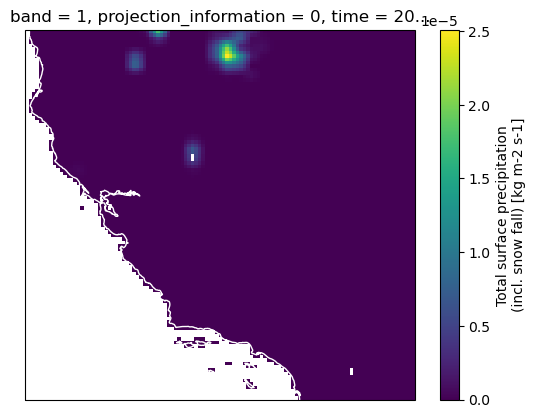

In [7]:
ds_SMAPL4 = ds_SMAPL4.sel(x=slice(minx, maxx), y=slice(miny, maxy))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(color='white')
ds_SMAPL4.sel(time='2016-01-01 01:30:00').precipitation_total_surface_flux.plot(ax=ax)
ds_SMAPL4

### Read SMAP L3 data

In [8]:
def _preprocess_SMAPL3(ds):
    # Assign missing time dimension
    # Doesn't care about hour amd minutes, as it is daily data
    startTime = datetime.strptime(ds.rangeBeginningDateTime.split("T")[0], '%Y-%m-%d')
    ds = ds.assign_coords(time=startTime)
    return ds

In [9]:
# Get a list of files 
# Test with 2016 Jan 1-9 data first
SMAPL3_fn_pattern = f'SMAP_L3_SM_P_E_{startDate.year}010*.nc' ####### CHNAGE LATER: testing with 2016 Jan 1-9 data #######
SMAPL3_file_paths = glob.glob(rf'{input_path}/{SMAPL3_path}/{SMAPL3_fn_pattern}')
# Load data
ds_SMAPL3 = xr.open_mfdataset(SMAPL3_file_paths, preprocess=_preprocess_SMAPL3, engine="rasterio", chunks=chunks, combine="nested", concat_dim="time")

In [10]:
ds_SMAPL3 = ds_SMAPL3.sel(x=slice(minx, maxx), y=slice(maxy, miny))
ds_SMAPL3
# 3.3 sec for 1 mo of data

<xarray.Dataset>
Dimensions:                 (band: 1, x: 113, y: 107, time: 9)
Coordinates:
  * band                    (band) int32 1
  * x                       (x) float64 -124.5 -124.4 -124.3 ... -114.1 -114.0
  * y                       (y) float64 42.43 42.33 42.24 ... 32.72 32.62 32.53
    /crs                    int32 0
  * time                    (time) datetime64[ns] 2016-01-01 ... 2016-01-09
Data variables:
    EASE_column_index       (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    longitude_pm            (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    retrieval_qual_flag_pm  (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    soil_moisture_pm        (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    EASE_row_index          (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    latitude                (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    longitude               (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    retrieval_qual_flag     (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    soil_moisture           (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    EASE_column_index_pm    (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    EASE_row_index_pm       (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
    latitude_pm             (time, band, y, x) float32 dask.array<chunksize=(1, 1, 44, 6), meta=np.ndarray>
Attributes: (12/82)
    antennaRotationRate:                  14.6
    description:                          A configuration file generated auto...
    identifier:                           L3_SM_P_E_SPS
    edition:                              1.0
    publicationDate:                      2013-02-08
    title:                                Product Specification Document for ...
    ...                                   ...
    identifier_product_DOI:               doi:10.5067/4DQ54OUIJ9DL
    longName:                             SMAP Enhanced L3 Radiometer Global ...
    mission:                              SMAP
    pointOfContact:                       National Snow and Ice Data Center
    resourceProviderOrganizationName:     National Aeronautics and Space Admi...
    revisionDate:                         2021-08-31

<xarray.DataArray 'soil_moisture' (time: 9, band: 1, y: 107, x: 113)>
dask.array<getitem, shape=(9, 1, 107, 113), dtype=float32, chunksize=(1, 1, 63, 100), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int32 1
  * x        (x) float64 -124.5 -124.4 -124.3 -124.2 ... -114.2 -114.1 -114.0
  * y        (y) float64 42.43 42.33 42.24 42.15 ... 32.81 32.72 32.62 32.53
    /crs     int32 0
  * time     (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2016-01-09
Attributes: (12/32)
    /Soil_Moisture_Retrieval_Data_AM/soil_moisture#coordinates:       /Soil_M...
    /Soil_Moisture_Retrieval_Data_AM/soil_moisture#DIMENSION_LABELS:  {y,x}
    /Soil_Moisture_Retrieval_Data_AM/soil_moisture#grid_mapping:      /crs
    /Soil_Moisture_Retrieval_Data_AM/soil_moisture#long_name:         Represe...
    /Soil_Moisture_Retrieval_Data_AM/soil_moisture#units:             cm**3/c...
    /Soil_Moisture_Retrieval_Data_AM/soil_moisture#valid_max:         0.5
    ...                                                               ...
    coordinates:                                                      /Soil_M...
    DIMENSION_LABELS:                                                 {y,x}
    long_name:                                                        Represe...
    units:                                                            cm**3/c...
    valid_max:                                                        0.5
    valid_min:                                                        0.02

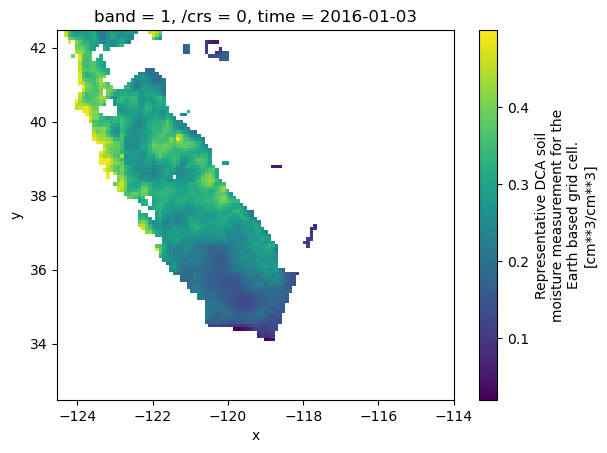

In [11]:
ds_SMAPL3.sel(time='2016-01-03').soil_moisture.plot()
ds_SMAPL3.soil_moisture
# TODO/IMPROVEMENT: Add dropna(how=all) somewhere to skip calculation of the ocean etc.

### Read Singer PET data

In [12]:
# Get a list of files 
PET_fn_pattern = f'*_daily_pet.nc'
PET_file_paths = glob.glob(rf'{input_path}/{PET_path}/{PET_fn_pattern}')

# Load data
ds_PET = xr.open_mfdataset(PET_file_paths, combine="nested", chunks=chunks, concat_dim="time", parallel=True)
ds_PET

<xarray.Dataset>
Dimensions:    (time: 2557, latitude: 1801, longitude: 3600)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2021-12-31
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
Data variables:
    pet        (time, latitude, longitude) float32 dask.array<chunksize=(365, 1801, 3600), meta=np.ndarray>

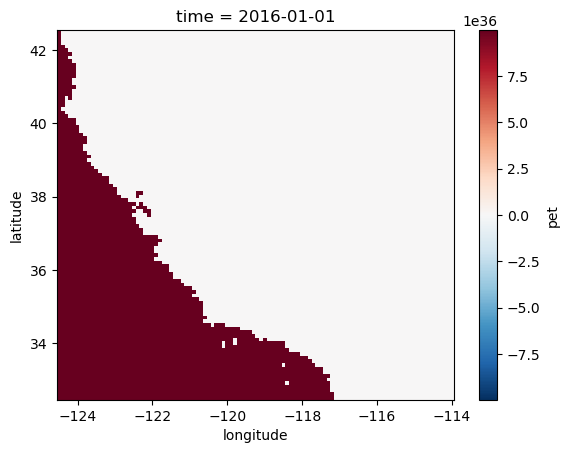

In [13]:
ds_PET_clipped = ds_PET.sel(longitude=slice(minx, maxx), latitude=slice(maxy, miny)).copy()
ds_PET_clipped.pet.sel(time='2016-01-01').plot()

## Processing data

### Get daily mean values

In [14]:
# SMAP L4
daily_P = ds_SMAPL4.precipitation_total_surface_flux.resample(time='D', skipna=True, keep_attrs=True).mean('time')

# SMAP L3
# Mask low-quality data
ds_SMAPL3['soil_moisture_am_masked'] = ds_SMAPL3.soil_moisture.where((ds_SMAPL3.retrieval_qual_flag == 0) | (ds_SMAPL3.retrieval_qual_flag == 8))
ds_SMAPL3['soil_moisture_pm_masked'] = ds_SMAPL3.soil_moisture_pm.where((ds_SMAPL3.retrieval_qual_flag_pm == 0) | (ds_SMAPL3.retrieval_qual_flag_pm == 8))
stacked_data = ds_SMAPL3[['soil_moisture_am_masked', 'soil_moisture_pm_masked']].to_array(dim='new_dim')
ds_SMAPL3['soil_moisture_daily'] = stacked_data.mean(skipna=True, dim="new_dim")

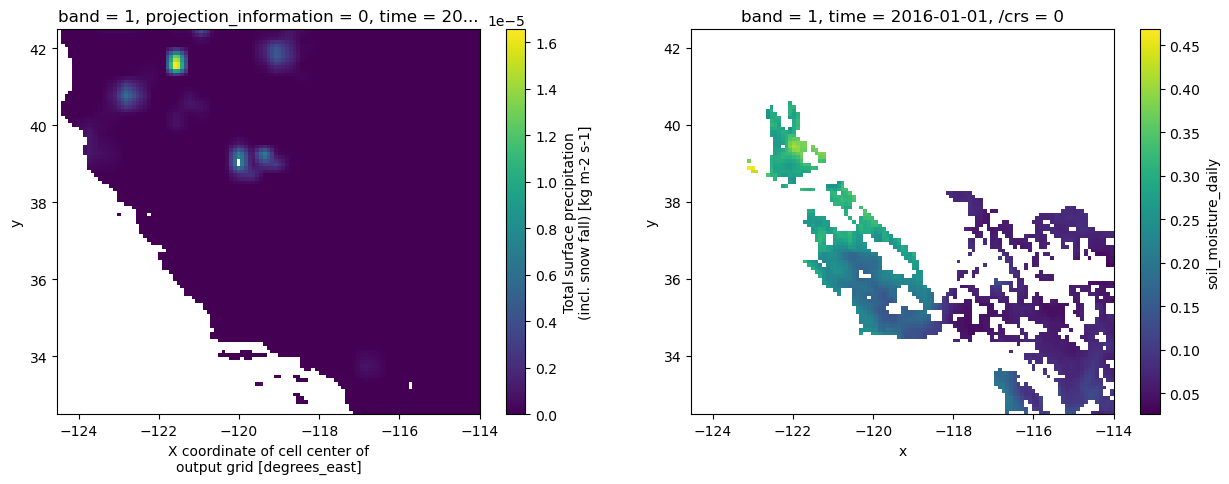

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
daily_P.sel(time='2016-01-01').plot(ax=ax1)
ds_SMAPL3.soil_moisture_daily.sel(time='2016-01-01').plot(ax=ax2)

### Calculate dS/dt

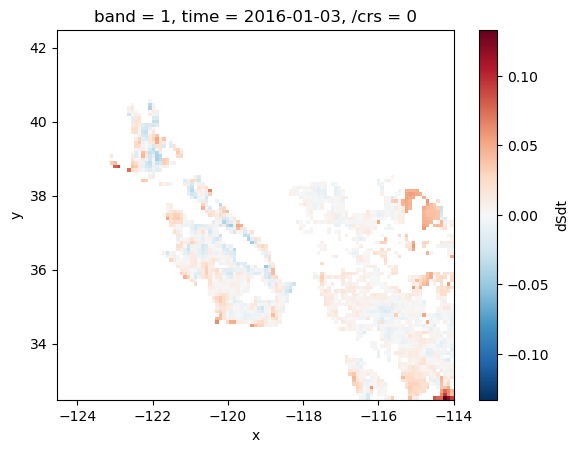

In [16]:
# Calculate dS/dt

# TODO/ISSUE: Mask by rainfall 

ds_SMAPL3['dS'] = ds_SMAPL3['soil_moisture_daily'].bfill(dim="time", limit=5).diff(dim="time").where(ds_SMAPL3['soil_moisture_daily'].notnull().shift(time=+1))
non_nulls = ds_SMAPL3['soil_moisture_daily'].isnull().cumsum(dim='time')
nan_length = non_nulls.where(ds_SMAPL3['soil_moisture_daily'].notnull()).bfill(dim="time")+1 - non_nulls +1
ds_SMAPL3['dt'] = nan_length.where(ds_SMAPL3['soil_moisture_daily'].isnull()).fillna(1)
ds_SMAPL3['dSdt'] = ds_SMAPL3['dS']/ds_SMAPL3['dt']
ds_SMAPL3['dSdt'] = ds_SMAPL3['dSdt'].shift(time=-1)

ds_SMAPL3['dSdt'].sel(time='2016-01-03').plot()

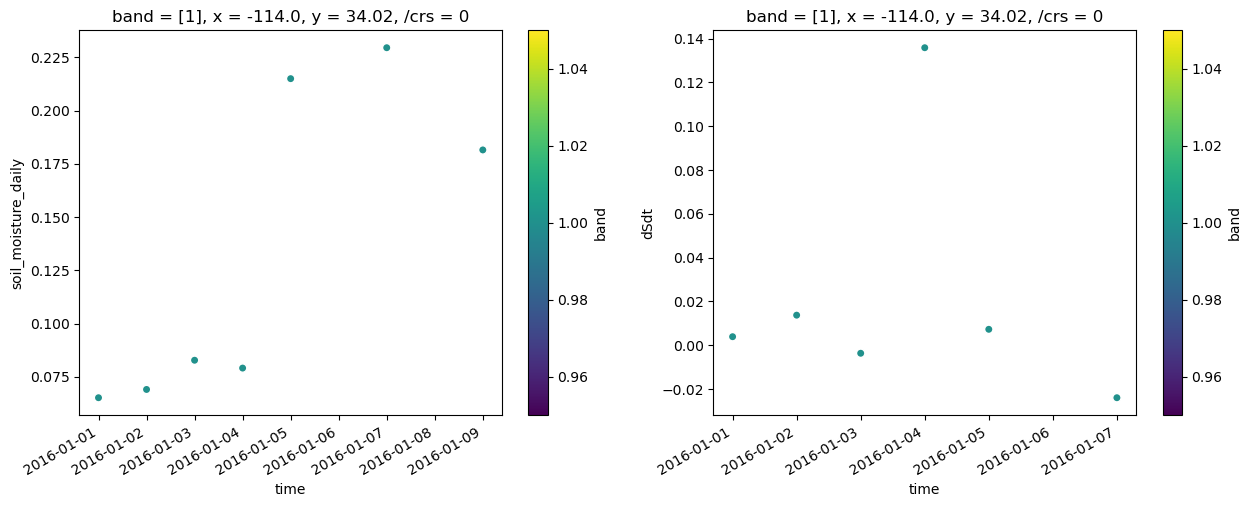

In [17]:
sample_x = -114
sample_y = 34
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ds_SMAPL3['soil_moisture_daily'].sel(x=sample_x, y=sample_y, method='nearest').interp(method='linear').plot.scatter(ax=ax1)
ds_SMAPL3['dSdt'].sel(x=sample_x, y=sample_y, method='nearest').interp(method='linear').plot.scatter(ax=ax2)

### Mask by precipitation

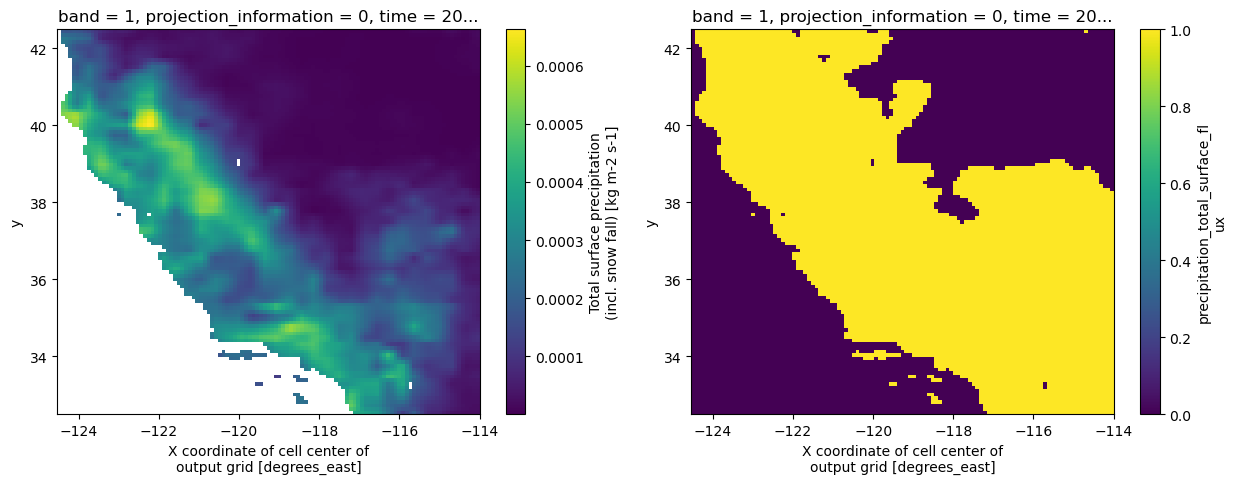

In [18]:
ds_SMAPL4_P = daily_P.load() # np.flip(ds_SMAPL4.precipitation_total_surface_flux.load(), axis=3)
ds_SMAPL4_P_mask = ds_SMAPL4_P > precip_thresh

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ds_SMAPL4_P.sel(time='2016-01-05').plot(ax=ax1)
ds_SMAPL4_P_mask.sel(time='2016-01-05').plot(ax=ax2)

# https://geohackweek.github.io/nDarrays/09-masking/

In [19]:
# Can't mask xarray with numpy array? 
ds_SMAPL3_masked = ds_SMAPL3.where(ds_SMAPL4_P_mask == True) # something like isel? 
ds_SMAPL3_masked

<xarray.Dataset>
Dimensions:                  (time: 9, band: 1, y: 0, x: 57)
Coordinates:
  * band                     (band) int32 1
  * x                        (x) float64 -124.5 -124.3 -124.1 ... -114.2 -114.0
  * y                        (y) float64 
  * time                     (time) datetime64[ns] 2016-01-01 ... 2016-01-09
    /crs                     int32 0
    projection_information   int32 0
Data variables: (12/18)
    EASE_column_index        (time, band, y, x) float32 dask.array<chunksize=(1, 1, 0, 3), meta=np.ndarray>
    longitude_pm             (time, band, y, x) float32 dask.array<chunksize=(1, 1, 0, 3), meta=np.ndarray>
    retrieval_qual_flag_pm   (time, band, y, x) float32 dask.array<chunksize=(1, 1, 0, 3), meta=np.ndarray>
    soil_moisture_pm         (time, band, y, x) float32 dask.array<chunksize=(1, 1, 0, 3), meta=np.ndarray>
    EASE_row_index           (time, band, y, x) float32 dask.array<chunksize=(1, 1, 0, 3), meta=np.ndarray>
    latitude                 (time, band, y, x) float32 dask.array<chunksize=(1, 1, 0, 3), meta=np.ndarray>
    ...                       ...
    soil_moisture_am_masked  (time, band, y, x) float32 dask.array<chunksize=(1, 1, 0, 3), meta=np.ndarray>
    soil_moisture_pm_masked  (time, band, y, x) float32 dask.array<chunksize=(1, 1, 0, 3), meta=np.ndarray>
    soil_moisture_daily      (time, band, y, x) float32 dask.array<chunksize=(1, 1, 0, 3), meta=np.ndarray>
    dS                       (time, band, y, x) float32 dask.array<chunksize=(2, 1, 0, 3), meta=np.ndarray>
    dt                       (time, band, y, x) float64 dask.array<chunksize=(1, 1, 0, 3), meta=np.ndarray>
    dSdt                     (time, band, y, x) float64 dask.array<chunksize=(1, 1, 0, 3), meta=np.ndarray>
Attributes: (12/82)
    antennaRotationRate:                  14.6
    description:                          A configuration file generated auto...
    identifier:                           L3_SM_P_E_SPS
    edition:                              1.0
    publicationDate:                      2013-02-08
    title:                                Product Specification Document for ...
    ...                                   ...
    identifier_product_DOI:               doi:10.5067/4DQ54OUIJ9DL
    longName:                             SMAP Enhanced L3 Radiometer Global ...
    mission:                              SMAP
    pointOfContact:                       National Snow and Ice Data Center
    resourceProviderOrganizationName:     National Aeronautics and Space Admi...
    revisionDate:                         2021-08-31

## Fit regression b/w dS/dt & S for upper/lower PET quantile

### Get upper/lower PET quantile

In [34]:
# Resample PET according to SMAPL3 grid
ds_PET_resampled = ds_PET.sel(longitude=ds_SMAPL3['x'], latitude=ds_SMAPL3['y'], method='nearest').copy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ds_PET.pet.sel(time='2016-01-01').plot(ax=ax1)
ds_PET_resampled.sel(time='2016-01-01').pet.plot(ax=ax2)

# TODO/ISSUE: The above line takes forever. ds_PET_resampled.sel(time='2016-01-01').pet.load() takes forever as well (like 1min)
# Cannot check the results

Task exception was never retrieved
future: <Task finished name='Task-124450' coro=<Client._gather.<locals>.wait() done, defined at c:\Users\raraki8159\.conda\envs\SMAP_v2\Lib\site-packages\distributed\client.py:2134> exception=AllExit()>
Traceback (most recent call last):
  File "c:\Users\raraki8159\.conda\envs\SMAP_v2\Lib\site-packages\distributed\client.py", line 2143, in wait
    raise AllExit()
distributed.client.AllExit


KeyboardInterrupt: 

In [21]:
# TODO/IMPROVEMENT: Want to mask by ds_SMAPL3_masked['ds'] < 0
ds_SMAPL3_masked = ds_SMAPL3.sel(band=1)

# ds_PET_resampled.rename({'longitude':'x', 'latitude':'y'})
# print(ds_PET_resampled.pet)
# print(ds_SMAPL3_masked)

In [22]:
# Get PET quantile values 
ds_PET_resampled = ds_PET_resampled.chunk({'time': len(ds_PET_resampled.time), 'x': 'auto', 'y': 'auto'})
ds_quantile = ds_PET_resampled.pet.quantile(dim="time", q=[lower_quantile_thresh, upper_quantile_thresh])
# https://stackoverflow.com/questions/73771129/rechunk-dataarray-to-calculate-90-quantile-over-over-chunked-time-dimension

ds_PET_quantile_upper = ds_PET_resampled.where(ds_PET_resampled.pet >= ds_quantile.sel(quantile=upper_quantile_thresh))
ds_PET_quantile_lower = ds_PET_resampled.where(ds_PET_resampled.pet <= ds_quantile.sel(quantile=lower_quantile_thresh))
print(ds_PET_quantile_upper)
print(ds_PET_quantile_lower)

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ds_PET_quantile_upper.pet.sel(time='2016-01-01')

# TODO/ISSUE: When I try to load this, it says it's 8GB! WTF. Cannot check the results
# TODO/ISSUE: It's the best if I can merge PET and SMAPL3 data, but dimention error occurs even if I drop/add dimentios 


<xarray.Dataset>
Dimensions:    (time: 2557, y: 107, x: 113)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2021-12-31
    latitude   (y) float32 dask.array<chunksize=(107,), meta=np.ndarray>
    longitude  (x) float32 dask.array<chunksize=(113,), meta=np.ndarray>
  * x          (x) float64 -124.5 -124.4 -124.3 -124.2 ... -114.2 -114.1 -114.0
    /crs       int32 0
  * y          (y) float64 42.43 42.33 42.24 42.15 ... 32.81 32.72 32.62 32.53
    quantile   float64 0.75
Data variables:
    pet        (time, y, x) float32 dask.array<chunksize=(2557, 107, 113), meta=np.ndarray>
<xarray.Dataset>
Dimensions:    (time: 2557, y: 107, x: 113)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2021-12-31
    latitude   (y) float32 dask.array<chunksize=(107,), meta=np.ndarray>
    longitude  (x) float32 dask.array<chunksize=(113,), meta=np.ndarray>
  * x          (x) float64 -124.5 -124.4 -124.3 -124.2 ... -114.2 -114.1 -114.0
    /crs      

<xarray.DataArray 'pet' (y: 107, x: 113)>
dask.array<getitem, shape=(107, 113), dtype=float32, chunksize=(107, 113), chunktype=numpy.ndarray>
Coordinates:
    time       datetime64[ns] 2016-01-01
    latitude   (y) float32 dask.array<chunksize=(107,), meta=np.ndarray>
    longitude  (x) float32 dask.array<chunksize=(113,), meta=np.ndarray>
  * x          (x) float64 -124.5 -124.4 -124.3 -124.2 ... -114.2 -114.1 -114.0
    /crs       int32 0
  * y          (y) float64 42.43 42.33 42.24 42.15 ... 32.81 32.72 32.62 32.53
    quantile   float64 0.75

In [23]:
# Get the minimum soil mositure values over the observation period for a given pixel
sm_min = ds_SMAPL3_masked.soil_moisture_daily.min(dim="time")

### Fit regression line

In [24]:
# TODO/ISSUE: Need to merge PET and SM to get dS/dt for upper and lower quantile of PET 
# ds_PET_quantile_upper

0.06520778


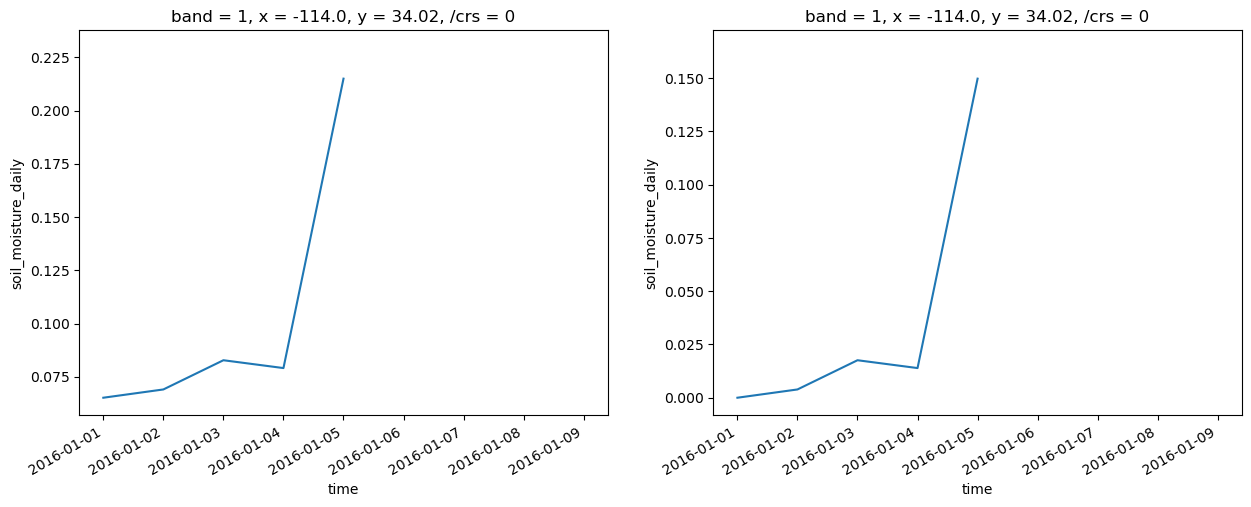

In [25]:
# Shift x values 
# ds_SMAPL3_masked.soil_moisture_daily.sel(time='2016-01-01').plot()

shifted_sm = ds_SMAPL3_masked.soil_moisture_daily - sm_min

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ds_SMAPL3_masked.soil_moisture_daily.sel(x=sample_x, y=sample_y, method='nearest').interp(method='linear').plot(ax=ax1)
shifted_sm.sel(x=sample_x, y=sample_y, method='nearest').interp(method='linear').plot(ax=ax2)
print(sm_min.sel(x=sample_x, y=sample_y, method='nearest').values)


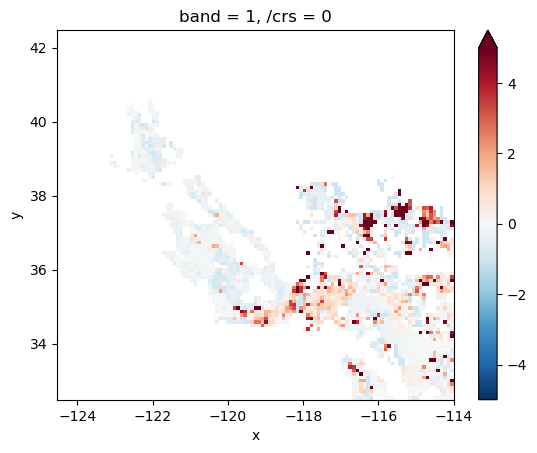

In [26]:
# Fit regression of linear line through the origin
# the slope a is calculated is: a = sum(xi * yi) / sum((xi)^2)
# Proofs in: 
# https://onlinelibrary.wiley.com/doi/10.1111/1467-9639.00136
# http://sites.msudenver.edu/ngrevsta/wp-content/uploads/sites/416/2020/02/Notes_07.pdf

# TODO: Calculate R2
numerator = shifted_sm * ds_SMAPL3_masked.dSdt
denominator = shifted_sm * shifted_sm
denominator_masked = denominator.where((~numerator.isnull()))
a = numerator.sum(dim="time", skipna=True) / denominator_masked.sum(dim="time", skipna=True)
a.plot(vmax=5)

[       nan 0.                nan 0.01480851 0.04027927        nan
        nan        nan        nan]
[       nan 0.00740425        nan 0.02547076        nan        nan
        nan        nan        nan]
0.056534898
[       nan 0.                nan 0.00037718        nan        nan
        nan        nan        nan]
[       nan 0.                nan 0.00021929 0.00162242        nan
        nan        nan        nan]
1.7200081147368669


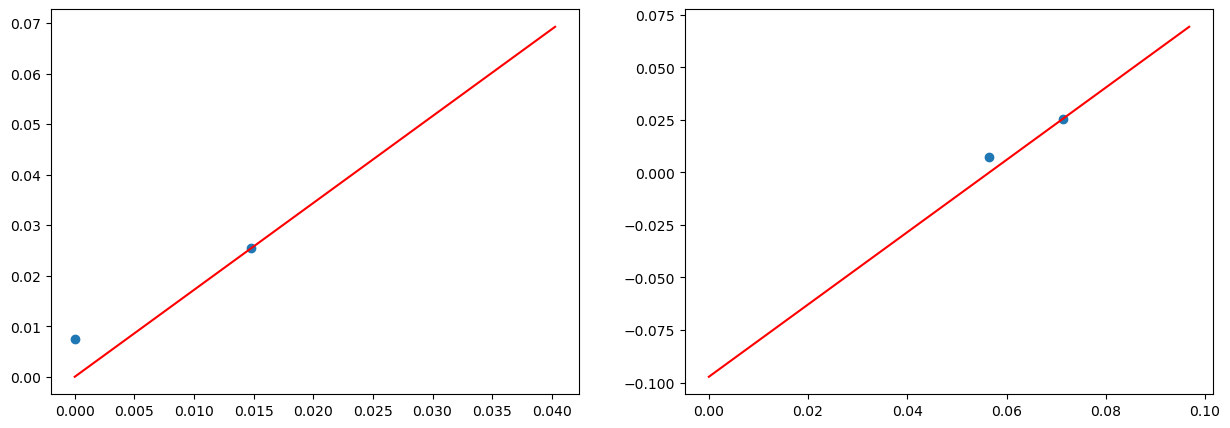

In [27]:
# Plot 
sample_x = -118
sample_y = 35
S = shifted_sm.sel(x=sample_x, y=sample_y, method='nearest').values
dSdt = ds_SMAPL3_masked.dSdt.sel(x=sample_x, y=sample_y, method='nearest').values
S_min = sm_min.sel(x=sample_x, y=sample_y, method='nearest').values
a_sel = a.sel(x=sample_x, y=sample_y, method='nearest').values

print(S)
print(dSdt)
print(S_min)
print(numerator.sel(x=sample_x, y=sample_y, method='nearest').values)
print(denominator.sel(x=sample_x, y=sample_y, method='nearest').values)
print(a_sel)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(S, dSdt)
x = np.linspace(0, np.nanmax(S),100)
y = a_sel*x # (x+S_min)
ax1.plot(x, y, '-r')

ax2.scatter(S+S_min, dSdt)
x = np.linspace(0, np.nanmax(S+S_min),100)
y = a_sel*x - a_sel*S_min 
ax2.plot(x, y, '-r')

# Some old snipped

In [28]:
# import netCDF4 as nc
# SMAPL4_fn_test = r"G:\Araki\SMSigxSMAP\1_data\SPL4SMGP\SMAP_L4_SM_gph_20180911T103000_Vv7032_001_HEGOUT.nc"
# ds_SMAPL4_test = xr.open_dataset(SMAPL4_fn_test, group='Geophysical_Data')

# SMAPL4_fn_test = r"G:\Araki\SMSigxSMAP\1_data\SPL4SMGP\SMAP_L4_SM_gph_20180911T103000_Vv7032_001_HEGOUT.nc"
# ds_SMAPL4_test = nc.Dataset(SMAPL4_fn_test)
# print(ds_SMAPL4_test)
# xr.open_dataset(xr.backends.NetCDF4DataStore(ds_SMAPL4_test))
# ds_SMAPL4_test_P = xr.open_dataset(xr.backends.NetCDF4DataStore(ds_SMAPL4_test['Geophysical_Data']))
# # ds_SMAPL4_test_x = xr.open_dataset(xr.backends.NetCDF4DataStore(ds_SMAPL4_test['x']))
# ds_SMAPL4_test_P = ds_SMAPL4_test_P.assign_coords({"x": ("x", ds_SMAPL4_test['x'][:]), "y": ("y", ds_SMAPL4_test['y'][:])})
# ds_SMAPL4_test_P.rio.write_crs('epsg:4326')

# import cartopy.crs as ccrs
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()
# ds_SMAPL4_test_P['precipitation_total_surface_flux'].plot(ax=ax)
# ds_SMAPL4_test_P